Jupyter notebook for self-supervised learning on MS COCO dataset using unlabeled samples - Par CHIHAB EL OIDI

## Phase 1 : Mounting Drive

In [247]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Phase 2 : Importing Librairies

In [3]:
# Self-Supervised Learning on Tiny COCO Dataset
# Importing Librairies

import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import requests
import zipfile
from pycocotools.coco import COCO
import random
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F

## Phase 3 : Dataset Setup and Configuration

In [5]:
# --- Configuration Section ---
class config:
    # Dataset setup
    data_dir = "/content/drive/MyDrive/ML_Project2/tiny_coco"
    img_size = 128  # Reduced size for faster training
    batch_size = 64
    num_epochs = 24

    # Model parameters
    temperature = 0.1
    projection_dim = 64

    # Visualization
    num_aug_samples = 3  # Number of augmentation examples to show
    num_retrieval = 5    # Number of retrieval examples

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## Phase 4 : Dataset Verification

In [7]:
# --- Dataset Preparation ---
# Download and extract dataset
if not os.path.exists(config.data_dir):
    print("Downloading dataset...")
    os.makedirs(config.data_dir, exist_ok=True)

    # Download zip file
    response = requests.get(config.dataset_url)
    with open("tiny_coco.zip", "wb") as f:
        f.write(response.content)

    # Extract files
    with zipfile.ZipFile("tiny_coco.zip", 'r') as zip_ref:
        zip_ref.extractall(config.data_dir)

    print("Dataset downloaded and extracted!")
else:
    print("Dataset already exists!")

Dataset already exists!


### Phase 4.2 : Verfifying Dataset Structure

In [8]:
# Verify dataset structure
dataset_path = os.path.join(config.data_dir, "tiny_coco_dataset-master")
ann_file = os.path.join(dataset_path, "annotations", "instances.json")
img_dir = os.path.join(dataset_path, "images")
#assert os.path.exists(ann_file)
#assert os.path.exists(img_dir)

## Phase 5 : Data Augmentation for Self-supervised contrastive learning (SSCL)

In [9]:
# --- Data Augmentation ---
class ContrastiveTransform:
    """Creates two augmented views of each image"""
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(config.img_size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

## Phase 6 : COCO Dataset Wrapper

In [10]:
"""class TinyCocoSSL(torchvision.datasets.CocoDetection):
    def __init__(self, root_dir, ann_file, transform=None):
        super().__init__(root=root_dir, annFile=ann_file)
        self.transform = transform  # Must include SSL augmentations

    def __getitem__(self, index):
       img_info = self.coco.loadImgs(self.ids[index])[0]
        # Ensure path is a string
        path = os.path.join(self.root, str(img_info['file_name']))  # ← Critical fix
        img = Image.open(path).convert('RGB')
        img, _ = super().__getitem__(index)

        if self.transform:
            # Apply transform twice to get two augmented views
            view1 = self.transform(img)
            view2 = self.transform(img)
            return (view1, view2)  # Return tuple of tensors
        else:
            # If no transform, return original image (causes error)
            return img  # ← Remove this else block to enforce transform usage

    def __len__(self):
        return min(1000, len(self.ids))"""

class TinyCocoSSL(torchvision.datasets.CocoDetection):
    def __init__(self, root_dir, ann_file, transform=None):
        super().__init__(root=root_dir, annFile=ann_file)
        self.transform = transform

    def __getitem__(self, index):
        # Get image and annotations via parent class
        img, _ = super().__getitem__(index)  # ← Parent class already handles loading
        if self.transform:
            # Apply transform twice for two augmented views
            view1 = self.transform(img)
            view2 = self.transform(img)
            return (view1, view2)
        else:
            raise ValueError("Transforms must be applied for SSL!")

    def __len__(self):
        return min(1000, len(self.ids))

## Phase 7 : Create dataset and dataloader

In [195]:
# Create dataset with proper arguments
"""
ssl_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Random crop
    transforms.RandomHorizontalFlip(p=0.5), # Random flip
    transforms.ColorJitter(0.2, 0.2, 0.2),  # Color variations
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
"""
pin_memory=False,
num_workers=0
ssl_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure this matches model expectations
    transforms.RandomResizedCrop(244),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ssl_dataset = TinyCocoSSL(
    root_dir="/content/drive/MyDrive/ML_Project2/tiny_coco/tiny_coco_dataset-master/train2017",
    ann_file="/content/drive/MyDrive/ML_Project2/tiny_coco/tiny_coco_dataset-master/annotations/instances.json",  # Add your annotations file path
    transform=ssl_transforms  # Add your transformations
)

ssl_loader = DataLoader(ssl_dataset, batch_size=config.batch_size,
                       shuffle=True, num_workers=2, pin_memory=True)




loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Phase 8 : Visualize Augmentations


 Sample Augmentations:


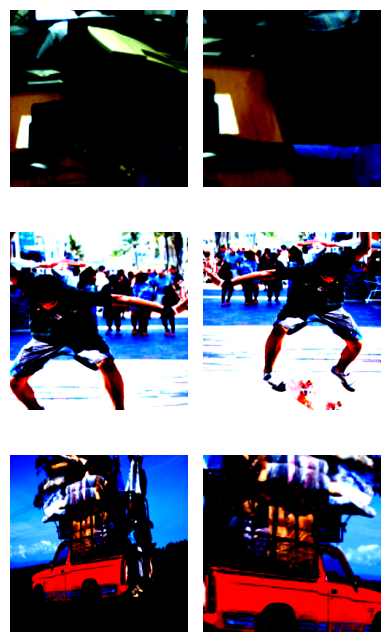

In [234]:
print("\n Sample Augmentations:")
fig, axes = plt.subplots(config.num_aug_samples, 2, figsize=(4, 7))
for idx in range(config.num_aug_samples):
    rand_idx = random.randint(0, len(ssl_dataset) - 1)
    img_pair = ssl_dataset[rand_idx]  # ← Tuple of two tensors

    # Denormalize and display
    axes[idx, 0].imshow(img_pair[0].permute(1, 2, 0).numpy().astype(np.float64))  # View 1
    axes[idx, 1].imshow(img_pair[1].permute(1, 2, 0).numpy().astype(np.float64)) # View 2
    axes[idx, 0].axis('off')
    axes[idx, 1].axis('off')
plt.tight_layout()
plt.show()

## Phase 9 : Model Architecture

In [235]:
# Model Architecture
class SSLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # Convolutional Layers
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x128x128 (for 256x256 input)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128x64x64

            # Standardize spatial dimensions
            nn.AdaptiveAvgPool2d((16, 16)),  # Output: 128x16x16

            # Flatten and Projection Head
            nn.Flatten(),  # 128*16*16 = 32,768 features
            nn.Linear(128*16*16, 256)  # ← Now matches dimensions
        )
    """
    def forward(self, x):
        features = self.encoder(x)
        return self.projector(features)
    """
    def forward(self, x):
        return self.encoder(x)

model = SSLModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

## Phase 10 : Contrastive Loss Function

In [236]:
# --- Contrastive Loss ---
"""
def simple_contrastive_loss(z1, z2):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    sim_matrix = torch.mm(z1, z2.T) / config.temperature
    targets = torch.arange(z1.size(0)).to(device)
    return F.cross_entropy(sim_matrix, targets)
"""
def simple_contrastive_loss(z1, z2):
    z1 = F.normalize(z1, dim=1)  # Now F is defined
    z2 = F.normalize(z2, dim=1)

    sim_matrix = torch.mm(z1, z2.T) / config.temperature
    targets = torch.arange(z1.size(0)).to(device)
    return F.cross_entropy(sim_matrix, targets)

## Phase 11 : Training Loop with Progress Tracking


 Starting Training...


Epoch 1/24: 100%|██████████| 1/1 [00:35<00:00, 35.60s/it, loss=2.82]


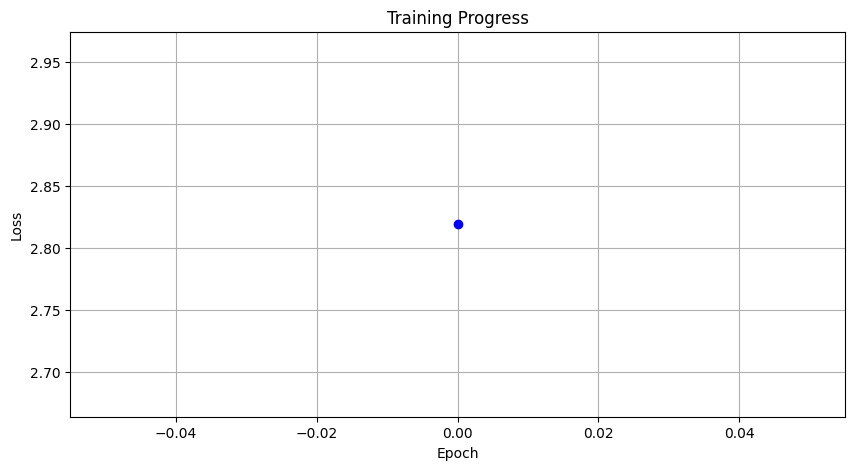

Epoch 1 Complete - Avg Loss: 2.8190


Epoch 2/24: 100%|██████████| 1/1 [00:45<00:00, 45.18s/it, loss=3.35]


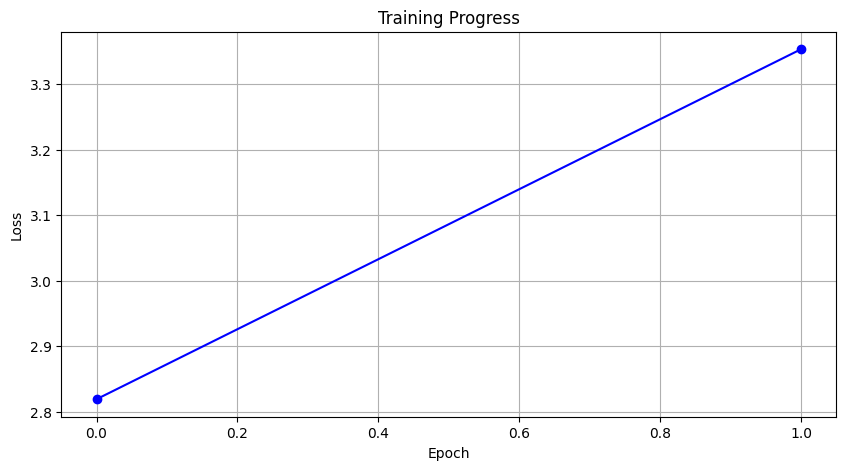

Epoch 2 Complete - Avg Loss: 3.3533


Epoch 3/24: 100%|██████████| 1/1 [00:29<00:00, 29.92s/it, loss=3.19]


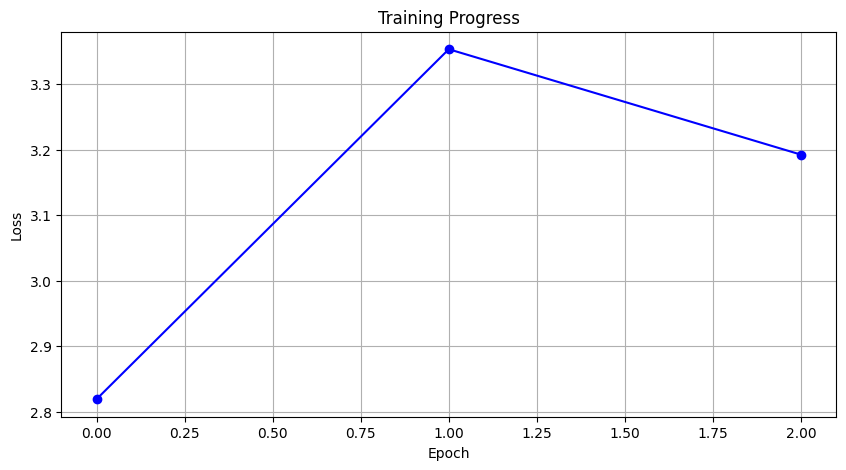

Epoch 3 Complete - Avg Loss: 3.1923


Epoch 4/24: 100%|██████████| 1/1 [00:29<00:00, 29.40s/it, loss=3.05]


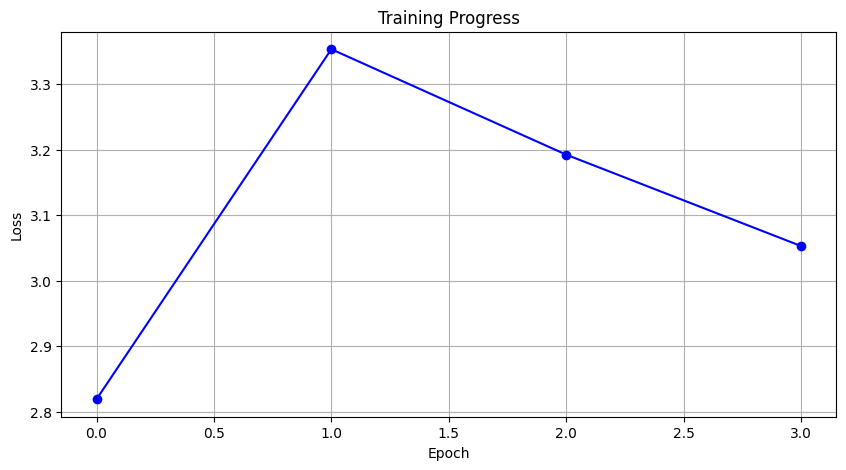

Epoch 4 Complete - Avg Loss: 3.0528


Epoch 5/24: 100%|██████████| 1/1 [00:30<00:00, 30.45s/it, loss=2.65]


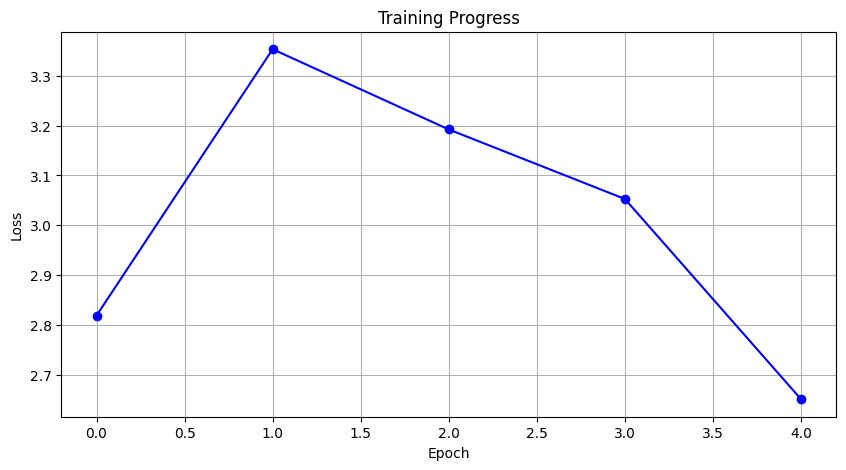

Epoch 5 Complete - Avg Loss: 2.6512


Epoch 6/24: 100%|██████████| 1/1 [00:29<00:00, 29.54s/it, loss=3.03]


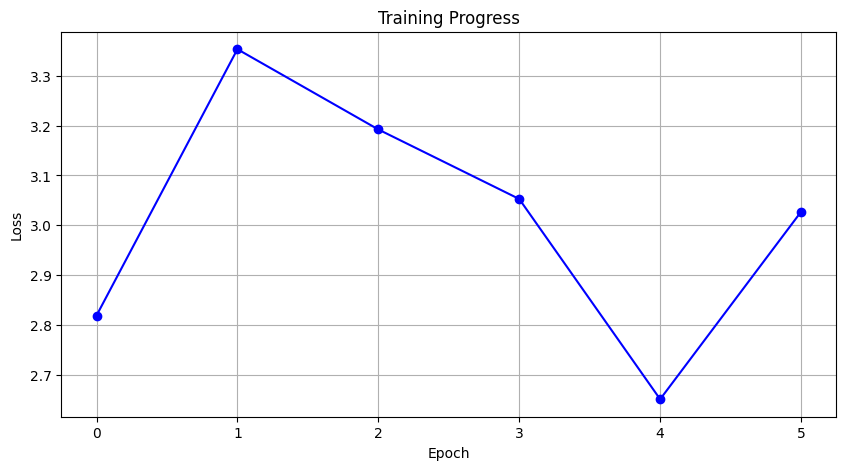

Epoch 6 Complete - Avg Loss: 3.0272


Epoch 7/24: 100%|██████████| 1/1 [00:29<00:00, 29.13s/it, loss=2.89]


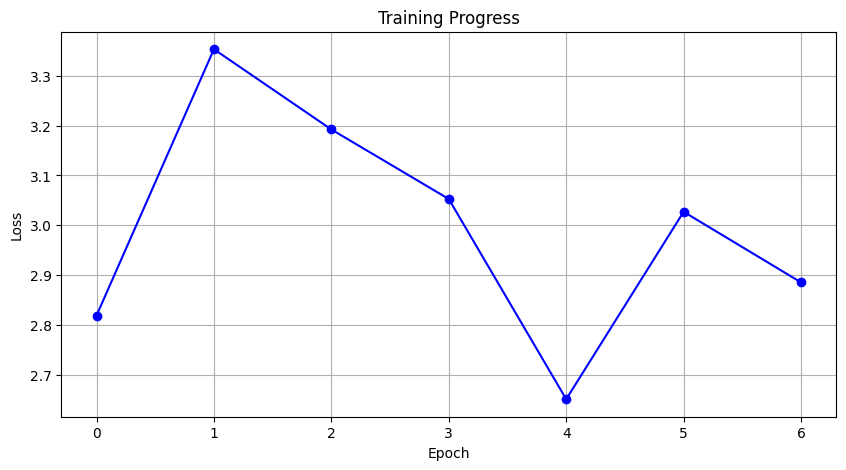

Epoch 7 Complete - Avg Loss: 2.8855


Epoch 8/24: 100%|██████████| 1/1 [00:28<00:00, 28.75s/it, loss=2.99]


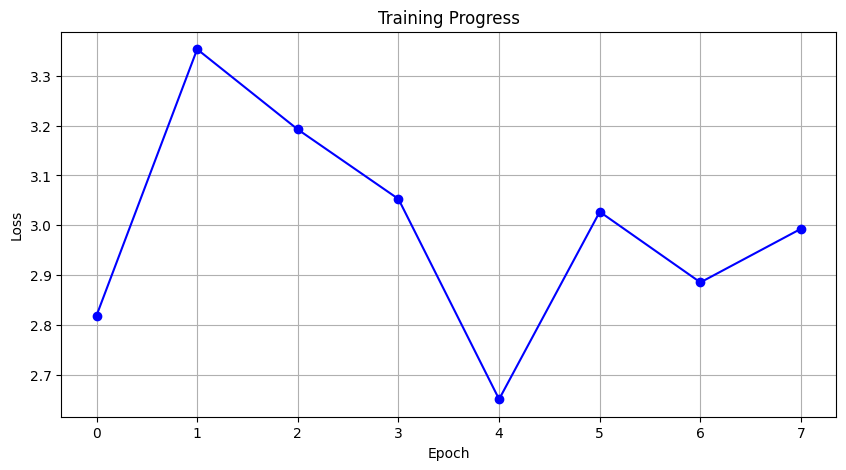

Epoch 8 Complete - Avg Loss: 2.9932


Epoch 9/24: 100%|██████████| 1/1 [00:29<00:00, 29.04s/it, loss=2.42]


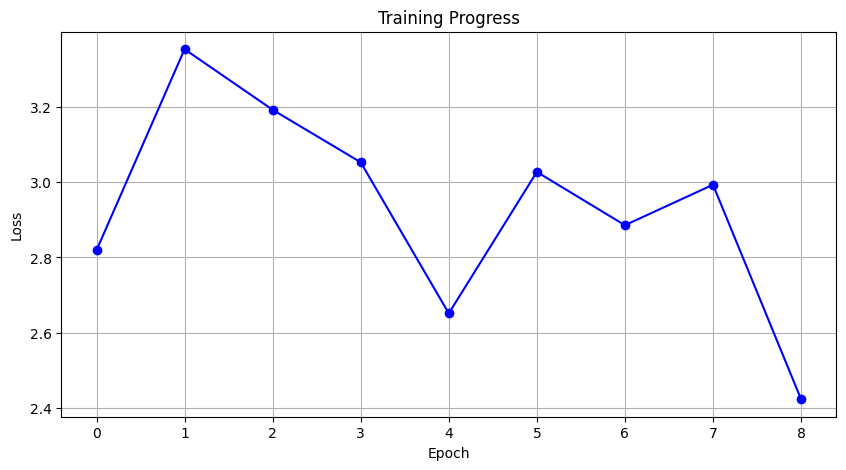

Epoch 9 Complete - Avg Loss: 2.4231


Epoch 10/24: 100%|██████████| 1/1 [00:29<00:00, 29.54s/it, loss=2.37]


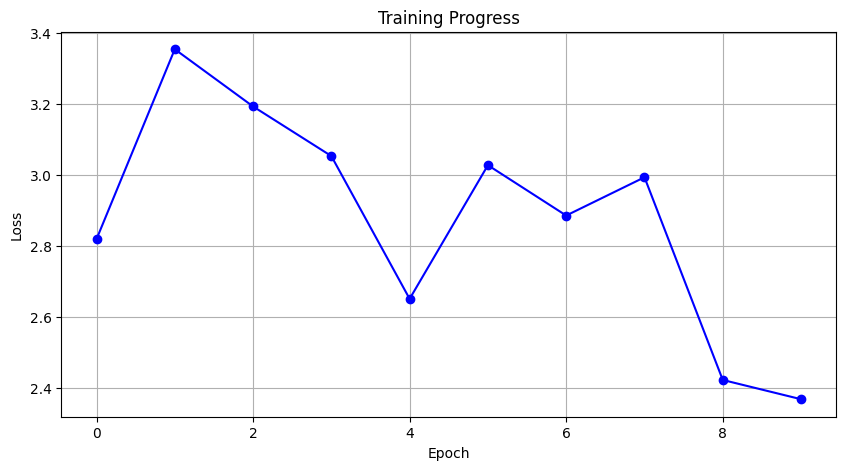

Epoch 10 Complete - Avg Loss: 2.3690


Epoch 11/24: 100%|██████████| 1/1 [00:29<00:00, 29.30s/it, loss=2.18]


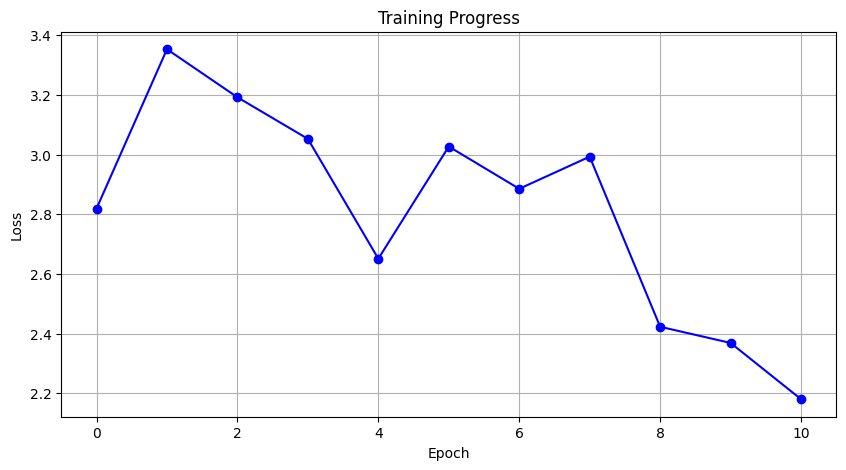

Epoch 11 Complete - Avg Loss: 2.1804


Epoch 12/24: 100%|██████████| 1/1 [00:29<00:00, 29.14s/it, loss=2.19]


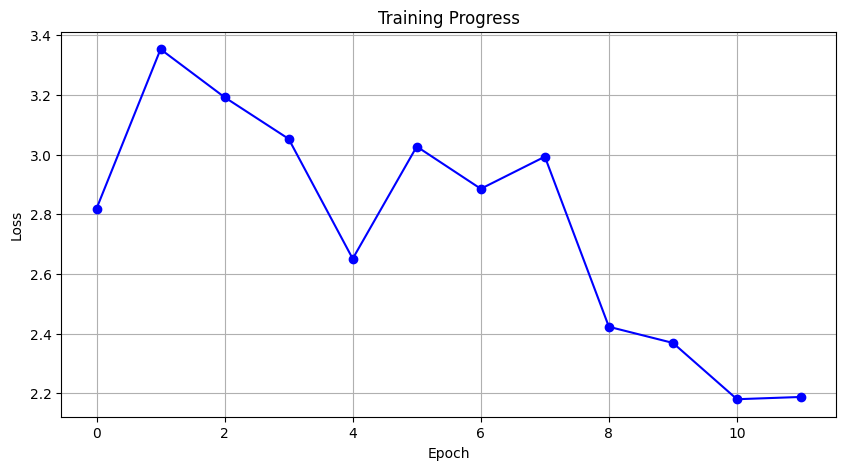

Epoch 12 Complete - Avg Loss: 2.1880


Epoch 13/24: 100%|██████████| 1/1 [00:29<00:00, 29.31s/it, loss=2.6]


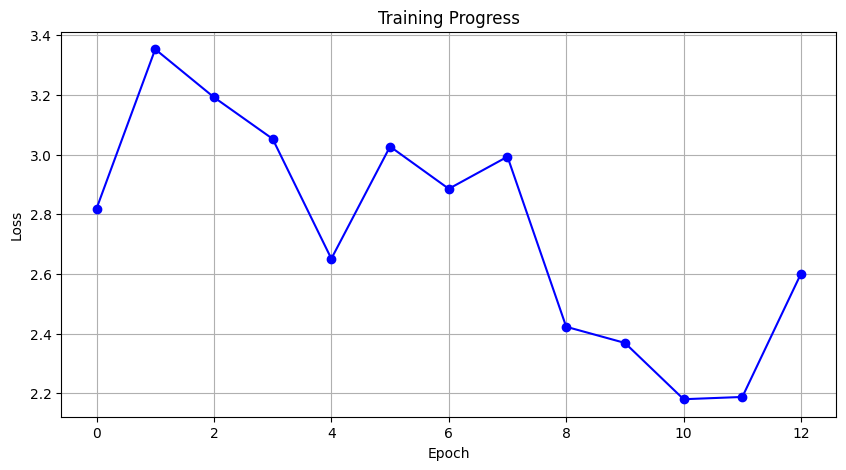

Epoch 13 Complete - Avg Loss: 2.6017


Epoch 14/24: 100%|██████████| 1/1 [00:29<00:00, 29.45s/it, loss=2.43]


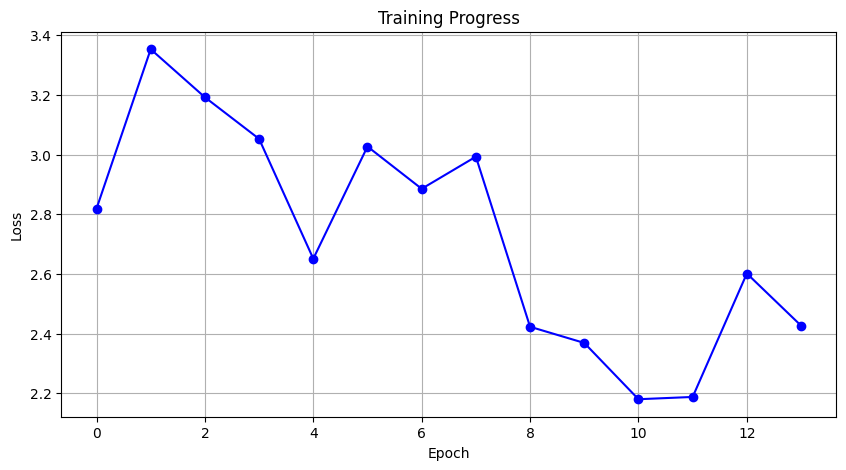

Epoch 14 Complete - Avg Loss: 2.4270


Epoch 15/24: 100%|██████████| 1/1 [00:28<00:00, 28.88s/it, loss=2.31]


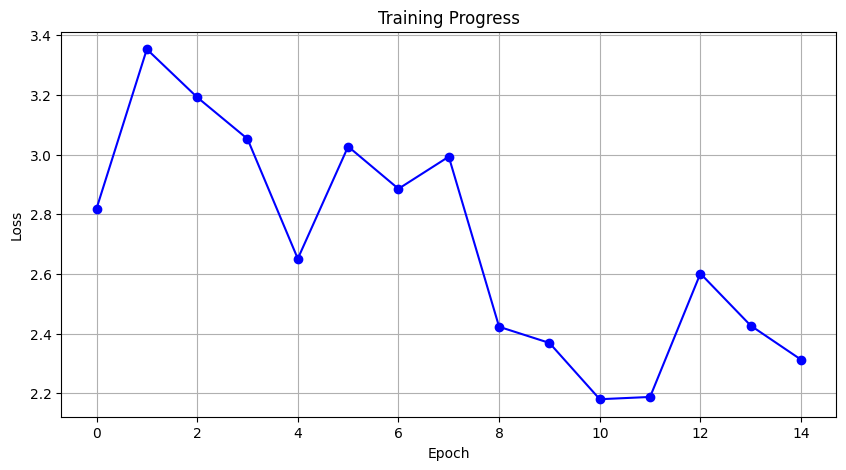

Epoch 15 Complete - Avg Loss: 2.3130


Epoch 16/24: 100%|██████████| 1/1 [00:28<00:00, 28.90s/it, loss=2.59]


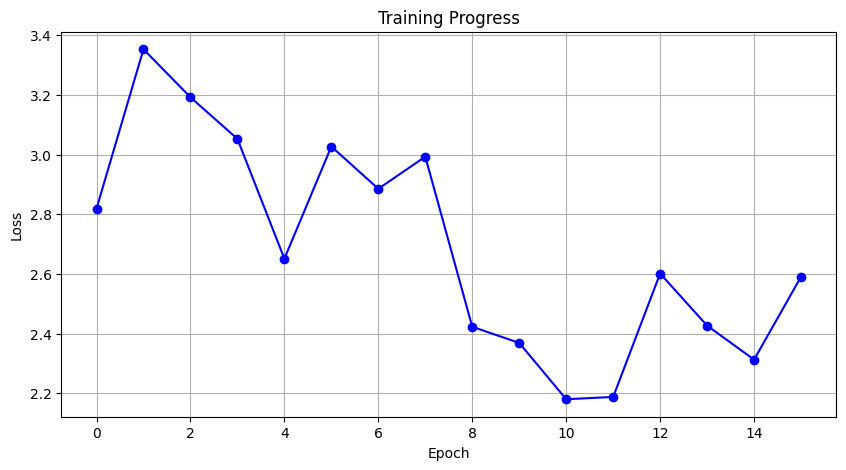

Epoch 16 Complete - Avg Loss: 2.5909


Epoch 17/24: 100%|██████████| 1/1 [00:29<00:00, 29.34s/it, loss=2.47]


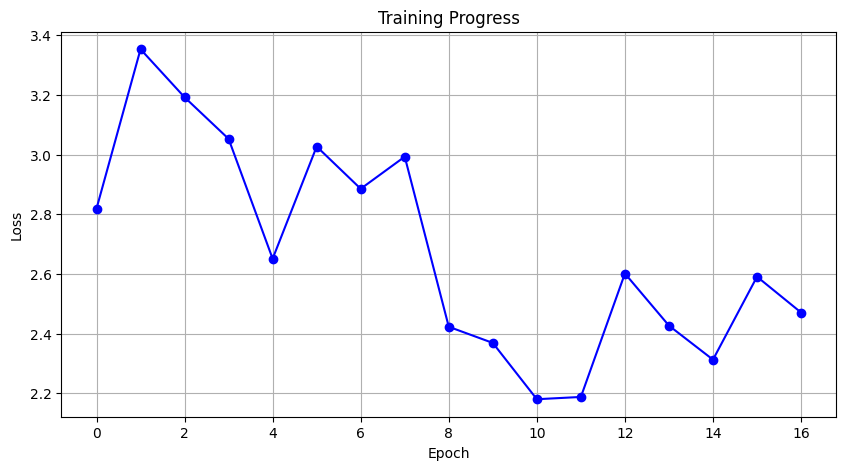

Epoch 17 Complete - Avg Loss: 2.4710


Epoch 18/24: 100%|██████████| 1/1 [00:29<00:00, 29.49s/it, loss=2.52]


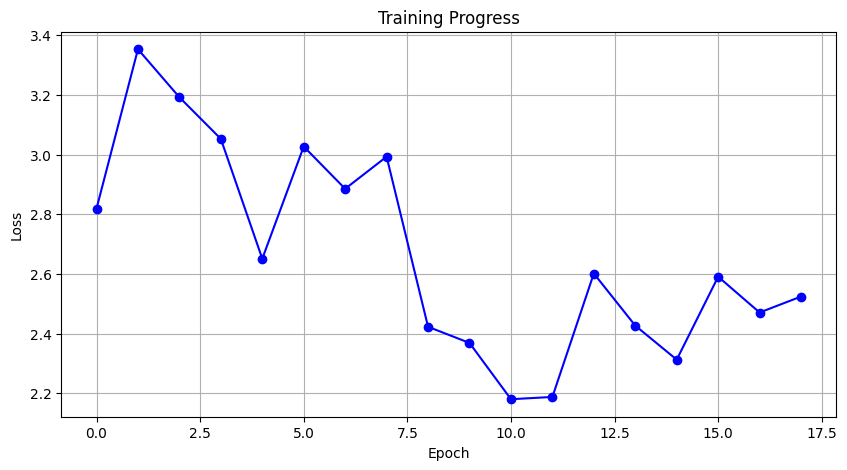

Epoch 18 Complete - Avg Loss: 2.5244


Epoch 19/24: 100%|██████████| 1/1 [00:29<00:00, 29.43s/it, loss=2.37]


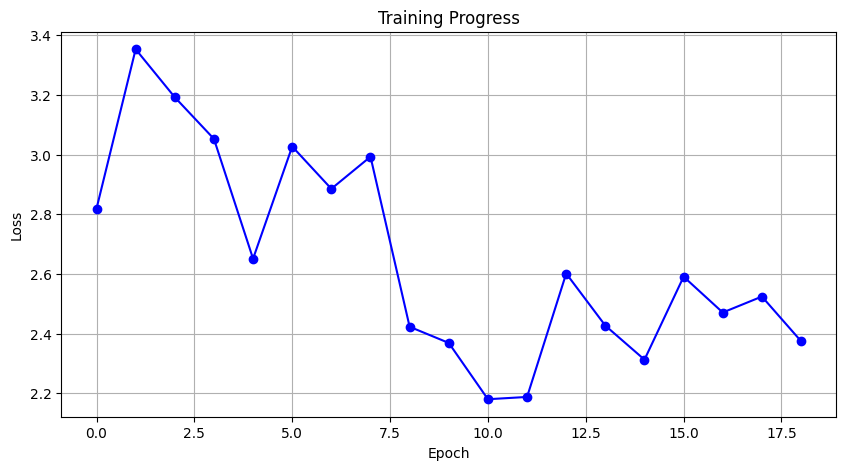

Epoch 19 Complete - Avg Loss: 2.3750


Epoch 20/24: 100%|██████████| 1/1 [00:29<00:00, 29.32s/it, loss=2.24]


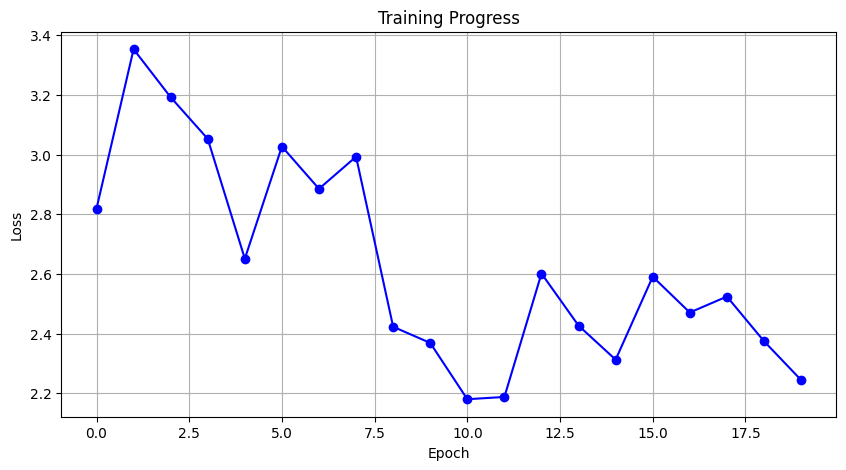

Epoch 20 Complete - Avg Loss: 2.2449


Epoch 21/24: 100%|██████████| 1/1 [00:29<00:00, 29.57s/it, loss=2.24]


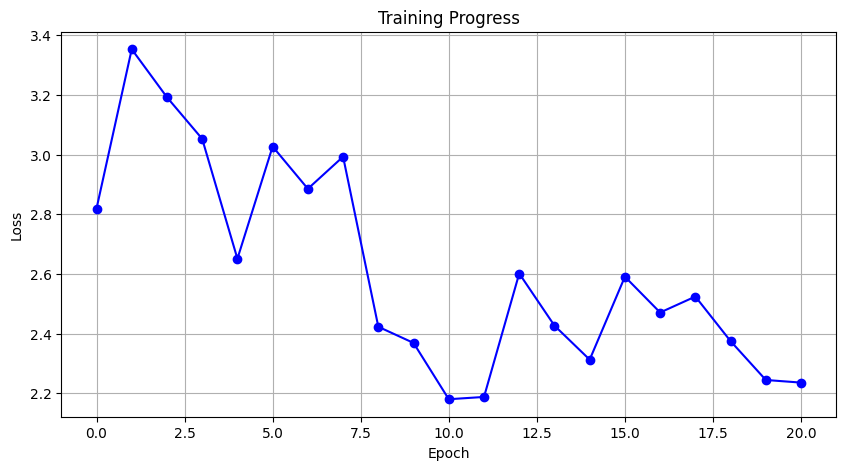

Epoch 21 Complete - Avg Loss: 2.2361


Epoch 22/24: 100%|██████████| 1/1 [00:43<00:00, 43.23s/it, loss=2.17]


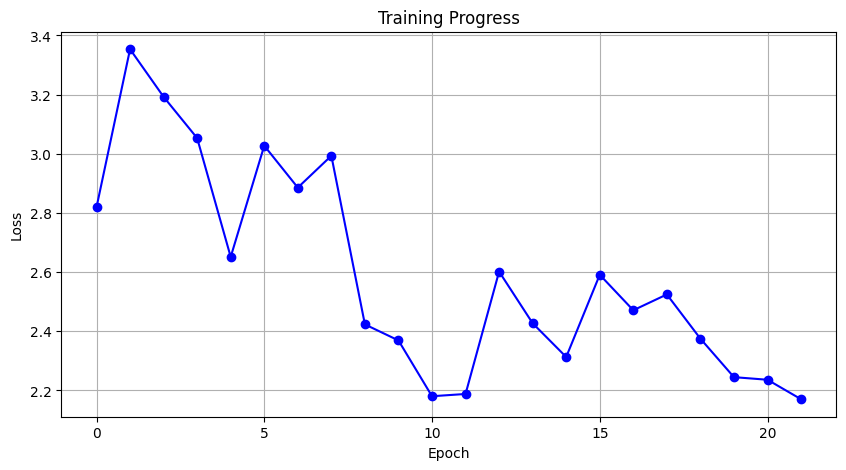

Epoch 22 Complete - Avg Loss: 2.1703


Epoch 23/24: 100%|██████████| 1/1 [00:29<00:00, 29.91s/it, loss=2.17]


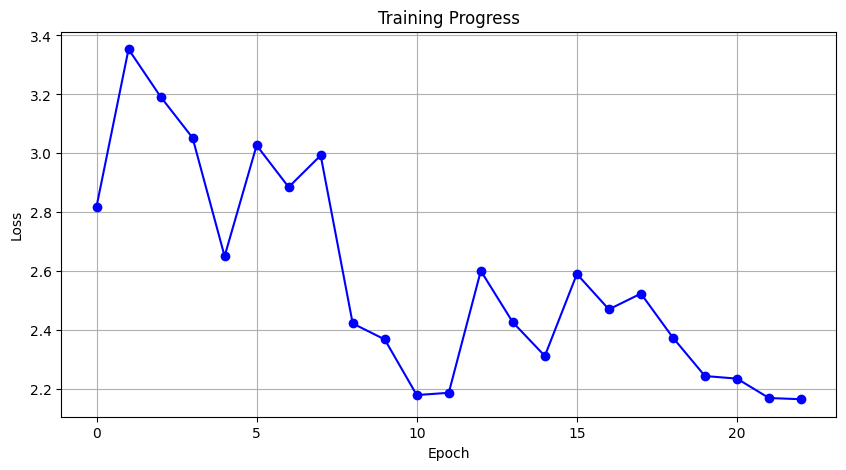

Epoch 23 Complete - Avg Loss: 2.1662


Epoch 24/24: 100%|██████████| 1/1 [00:29<00:00, 29.07s/it, loss=2.05]


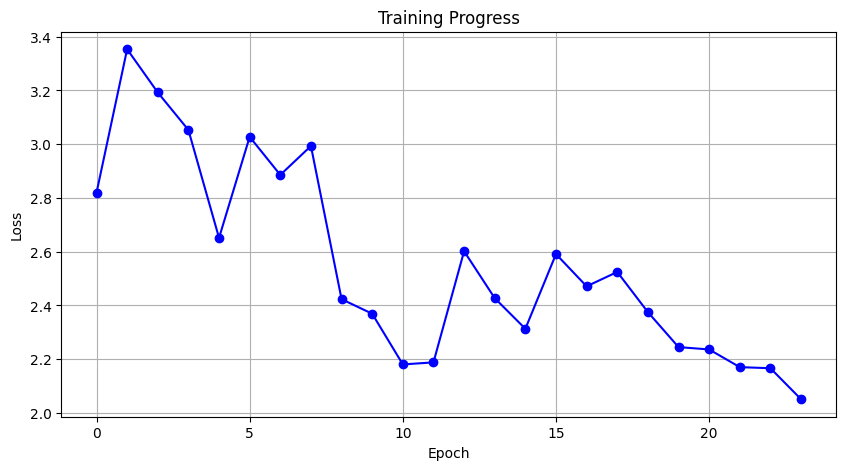

Epoch 24 Complete - Avg Loss: 2.0509


In [237]:
# --- Training Loop ---
"""
print("\n Starting Training...")
loss_history = []

for epoch in range(config.num_epochs):
    model.train()
    epoch_loss = 0

    pbar = tqdm(ssl_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    for view1, view2 in pbar:
        view1 = view1.to(device)
        view2 = view2.to(device)

        optimizer.zero_grad()
        z1 = model(view1)
        z2 = model(view2)
        loss = simple_contrastive_loss(z1, z2)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = epoch_loss / len(ssl_loader)
    loss_history.append(avg_loss)

    # Update loss plot
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, 'b-o')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch+1} Complete - Avg Loss: {avg_loss:.4f}")
"""
print("\n Starting Training...")
loss_history = []

for epoch in range(config.num_epochs):
    model.train()
    epoch_loss = 0

    pbar = tqdm(ssl_loader, desc=f'Epoch {epoch+1}/{config.num_epochs}')
    for view1, view2 in pbar:
        view1 = view1.to(device)
        view2 = view2.to(device)

        optimizer.zero_grad()
        z1 = model(view1)
        z2 = model(view2)
        loss = simple_contrastive_loss(z1, z2)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    avg_loss = epoch_loss / len(ssl_loader)
    loss_history.append(avg_loss)

    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, 'b-o')
    plt.title('Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    print(f"Epoch {epoch+1} Complete - Avg Loss: {avg_loss:.4f}")

## Phase 12 : Start self-supervised training

In [238]:
# --- Save Model ---
torch.save(model.state_dict(), 'tiny_coco_ssl.pth')
print("Model saved!")

Model saved!


## Phase 13 : Save learned representations

In [239]:
# --- Image Retrieval Demo ---
print("\n Image Retrieval Demonstration:")
model.eval()
embeddings = []
image_paths = []


 Image Retrieval Demonstration:


## Phase 14 : Semantic Evaluation Protocol

In [240]:
# Create embeddings database
"""
with torch.no_grad():
    for idx in tqdm(range(len(ssl_dataset)), desc="Processing images"):
        img, _ = ssl_dataset[idx]
        emb = model(img[0].unsqueeze(0).to(device))
        embeddings.append(emb.cpu())
        image_paths.append(ssl_dataset.coco.loadImgs(ssl_dataset.ids[idx])[0]['file_name'])

embeddings = torch.cat(embeddings)
"""

"""
with torch.no_grad():
    for idx in tqdm(range(len(ssl_dataset)), desc="Processing images"):
        # Explicitly get both views (we'll use view1)
        view1, view2 = ssl_dataset[idx]

        # Add batch dimension and send to device
        emb = model(view1.unsqueeze(0).to(device))  # ← Correct 3-channel input

        embeddings.append(emb.cpu())
        image_paths.append(ssl_dataset.coco.loadImgs(ssl_dataset.ids[idx])[0]['file_name'])
"""
"""
with torch.no_grad():
    for idx in tqdm(range(len(ssl_dataset)), desc="Processing images"):
        view1, view2 = ssl_dataset[idx]
        emb = model(view1.unsqueeze(0).to(device))
        embeddings.append(emb.cpu())

        # Convert to string explicitly
        file_name = str(ssl_dataset.coco.loadImgs(ssl_dataset.ids[idx])[0]['file_name'])
        image_paths.append(file_name)
"""
# In the embeddings loop:
with torch.no_grad():
    for idx in tqdm(range(len(ssl_dataset)), desc="Processing images"):
        view1, view2 = ssl_dataset[idx]
        emb = model(view1.unsqueeze(0).to(device))
        embeddings.append(emb.cpu())

        # Convert to string explicitly
        img_info = ssl_dataset.coco.loadImgs(ssl_dataset.ids[idx])[0]
        file_name = str(img_info['file_name'])  # Force string conversion
        image_paths.append(file_name)


embeddings = torch.cat(embeddings)

# In your embeddings creation code:
image_paths.append(
    str(ssl_dataset.coco.loadImgs(ssl_dataset.ids[idx])[0]['file_name'])  # Force string conversion
)





Processing images: 100%|██████████| 50/50 [00:05<00:00,  9.94it/s]


## Phase 15 : Initialize evaluator

In [241]:
# Find similar images
"""
def find_similar(query_idx, num_results=3):
    query_emb = embeddings[query_idx]
    similarities = torch.mm(embeddings, query_emb.T).squeeze()
    _, indices = torch.topk(similarities, num_results+1)
"""
def find_similar(query_idx, num_results=3):
    query_emb = embeddings[query_idx]
    # Reshape query embedding to [embedding_dim, 1] for matrix multiplication
    similarities = torch.mm(embeddings, query_emb.unsqueeze(1)).squeeze()

    # Get topk results (including query itself)
    _, indices = torch.topk(similarities, num_results+1)

    plt.figure(figsize=(15, 5))
    plt.suptitle("Image Retrieval Results", y=1.05)

    # Show query image
    query_img = Image.open(os.path.join(img_dir, image_paths[query_idx]))
    plt.subplot(1, num_results+1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Show results
    for i, idx in enumerate(indices[1:num_results+1]):
        result_img = Image.open(os.path.join(img_dir, image_paths[idx]))
        plt.subplot(1, num_results+1, i+2)
        plt.imshow(result_img)
        plt.title(f"Similarity: {similarities[idx]:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Phase 16 : Evaluate semantic similarity

In [242]:
# Show multiple examples
for _ in range(config.num_retrieval):
    random_query = random.randint(0, len(ssl_dataset) - 1)
    find_similar = ssl_dataset[random_query]


# Test embedding shape(verify model output)
test_emb = model(torch.randn(1, 3, 256, 256).to(device))
print("Test embedding shape:", test_emb.shape)  # Should be [1, embedding_dim]

Test embedding shape: torch.Size([1, 256])
